# Notebook to test the new dataset class for SKM-TEA Data,
# and to try external validation using OAI-trained 3D UNet.

In [36]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import glob
import os
import sys
import json
import matplotlib.pyplot as plt
sys.path.append('../')
from src.model_UNet import UNet3D
from src.metrics import bce_dice_loss, dice_coefficient, batch_dice_coeff
from src.datasets import SKMTEASegDataset
from src.utils import crop_im, undo_crop
from src.skmtea_utils import output_to_skmtea_pad_resize, skmtea_to_input_resize_crop

In [37]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [38]:
# Define data path to the external hard drive
home_dir = os.path.expanduser("~")
DATA_DIR = home_dir+'/../../Volumes/My Book Duo/skmtea/qdess/v1-release/image_files/'

In [39]:
# Get the test paths
# image_paths = np.sort(np.array([os.path.basename(i) for i in glob.glob(f'{DATA_DIR}/*')]))

# annotations path
ann_dir_path = DATA_DIR + '../annotations/v1.0.0/'

# Path to the JSON file
file_path = "test.json"

# Open and load the JSON file
with open(ann_dir_path + file_path, "r") as file:
    data = json.load(file)

# Access each part of the JSON structure
info = data["info"]
categories = data["categories"]
images = data["images"]
annotations = data["annotations"]

In [40]:
test_ims_df = pd.DataFrame(images)
test_ims_df.head()

,id,file_name,msp_id,msp_file_name,scan_id,subject_id,timepoint,voxel_spacing,matrix_shape,orientation,num_echoes,inspected
0,1,MTR_005.h5,0000099_V00,0000099_V00.h5,MTR_005,99,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
1,2,MTR_006.h5,0000164_V00,0000164_V00.h5,MTR_006,164,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
2,3,MTR_030.h5,0000249_V00,0000249_V00.h5,MTR_030,249,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
3,4,MTR_034.h5,0000117_V00,0000117_V00.h5,MTR_034,117,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True
4,5,MTR_048.h5,0000216_V00,0000216_V00.h5,MTR_048,216,0,"[0.3125, 0.3125, 0.8]","[512, 512, 160]","[SI, AP, LR]",2,True


In [41]:
image_paths = test_ims_df['file_name'].to_numpy()

In [43]:
print(image_paths[:5])
print(f"Num. images: {len(image_paths)}")

['MTR_005.h5' 'MTR_006.h5' 'MTR_030.h5' 'MTR_034.h5' 'MTR_048.h5']
Num. images: 36


In [44]:
# Create dataset and dataloader
skmtea_ds = SKMTEASegDataset(image_paths, DATA_DIR)
skmtea_dl = DataLoader(skmtea_ds, batch_size=1, shuffle=False)

In [48]:
# Test that we are getting images and masks
image, mask = next(iter(skmtea_dl))
print(image.shape)
print(mask.shape)

torch.Size([1, 1, 200, 256, 160])
torch.Size([1, 1, 512, 512, 160])


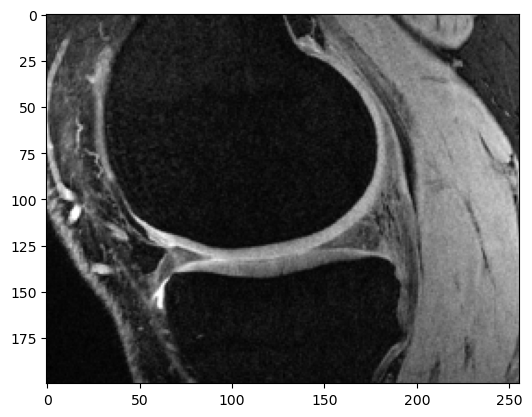

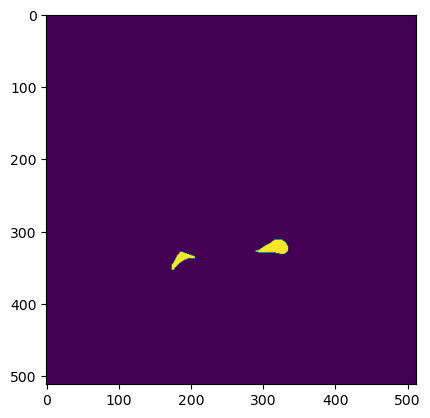

In [49]:
# turn to numpy and plot image and mask
np_im = image.squeeze(0).squeeze(0).numpy()
plt.imshow(np_im[...,100], cmap='gray')
plt.show()

np_mask = mask.squeeze(0).squeeze(0).numpy()
plt.imshow(np_mask[...,100])
plt.show()

In [50]:
model_dir = home_dir+'/CDT_no_icloud/model_saves/'
model_path = 'unet_with_aug_all_data_bs4_60e_best_E.pth'

In [51]:
unet = UNet3D(1, 1, 16)
#load trained model
PATH = model_dir + model_path
state_dict = torch.load(PATH, map_location=device)

# Sometimes, the model dictionary keys contain 'module.' prefix which we don't want
remove_prefix = True

if remove_prefix:
    remove_prefix = 'module.'
    state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

unet.load_state_dict(state_dict)
unet.eval();


In [52]:
unet.to(device)
image = image.to(device)
out = unet(image)

: 

In [ ]:
out.shape

torch.Size([1, 1, 200, 256, 160])

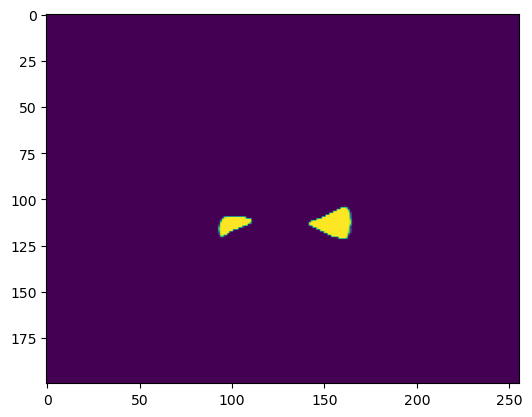

In [ ]:
np_pred = out.squeeze(0).squeeze(0).detach().cpu().numpy()
plt.imshow(np_pred[...,100])
plt.show()

In [ ]:
# Turn to a binary mask
pred_binary = (np_pred>0.5).astype(int)

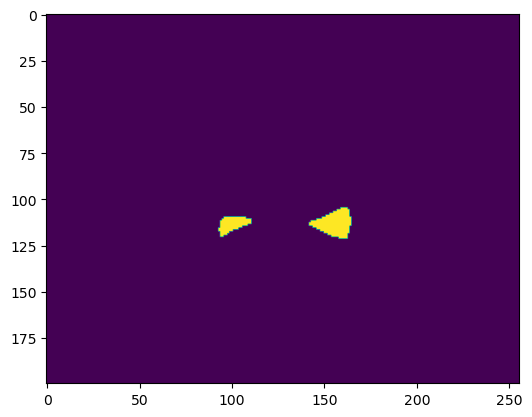

In [ ]:
plt.imshow(pred_binary[...,100])
plt.show()

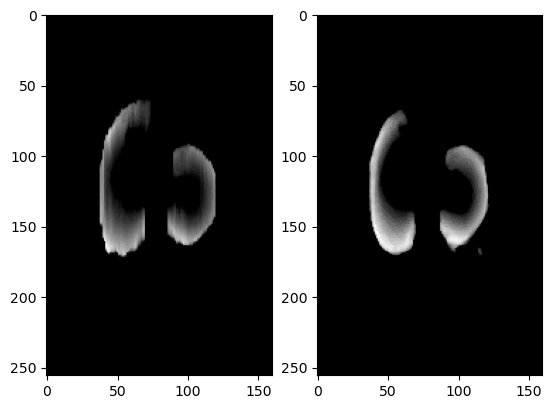

In [ ]:
# show proj view from above
fig, ax = plt.subplots(1, 2)

ax[0].imshow(np.sum(skmtea_to_input_resize_crop(np_mask), axis=0), cmap = 'gray')
ax[1].imshow(np.sum(pred_binary, axis=0), cmap = 'gray')
plt.show()


In [ ]:
# Undo the crop and resize
resized_pred_t = output_to_skmtea_pad_resize(pred_binary)


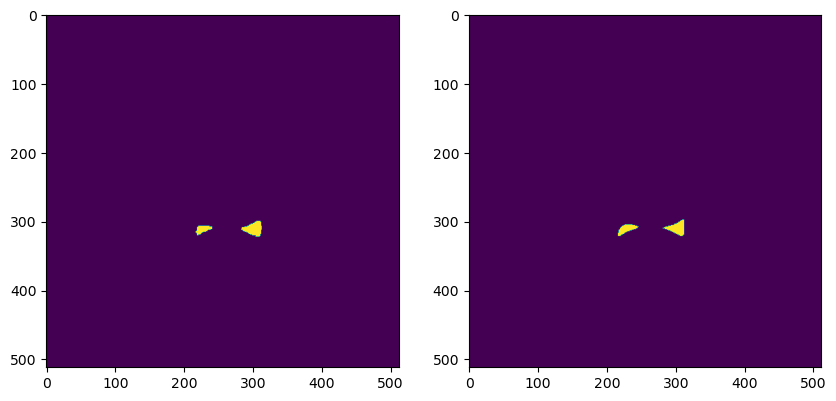

In [ ]:
# compare the gt and the pred
fig, ax = plt.subplots(1, 2, figsize = (10,5))

ax[0].imshow(resized_pred_t.squeeze(0).squeeze(0).numpy()[...,100])
ax[1].imshow(mask.squeeze(0).squeeze(0).numpy()[...,100])
plt.show()

In [ ]:
print(f"Dice score of {100 * dice_coefficient(mask, resized_pred_t):.2f}%")

Dice score of 2.23%


## Cycle through the test images and calculate dice score of each one, and save mask outputs

In [ ]:
from tqdm import tqdm

# First create folder for output masks
output_dir = DATA_DIR + 'mask_predictions'
os.makedirs(output_dir, exist_ok=True)

dice_scores = []

unet.to(device)

# Cycle through dataloader
for idx, (im, mask) in enumerate(tqdm(skmtea_dl)):
    im = im.to(device)
    out = unet(im)
    out = out.detach().cpu().squeeze(0).squeeze(0).numpy()

    pred_mask = (out>0.5).astype(int)

    # transform output to skmtea dimensions
    resized_pred_t = output_to_skmtea_pad_resize(pred_mask)

    # calculate dice score and overwrite as lowest if it is indeed the lowest
    dice = dice_coefficient(mask, resized_pred_t)
    dice_scores.append(dice)
    print(f"Im {idx+1}: Dice = {dice}")

    resized_pred_np = resized_pred_t.squeeze(0).squeeze(0).numpy()

    # save mask
    np.save(output_dir + image_paths[idx], resized_pred_np)

In [ ]:
# Loop to print out dice scores from the array
for idx, dice_score in enumerate(dice_scores):
    print(f"Dice score for image {idx+1}: {dice_score:.2f}")

# Print out mean dice score
print(f"Mean Dice score: {np.mean(dice_scores):.2f}")